In [1]:
# %pip install numpy scipy matplotlib oasis-deconv

In [2]:
import numpy as np
from scipy.signal import convolve, deconvolve, windows
import matplotlib.pyplot as plt
from oasis.functions import deconvolve as oasis_deconvolve

c:\Users\sangeetha\miniforge3\envs\calim\Lib\site-packages\oasis\functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


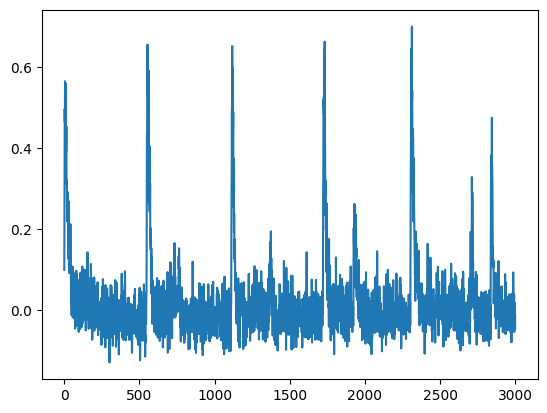

In [3]:
spks = np.load("data/spks.npy")
traces = np.load("data/F.npy")
spike_trace = spks[11]
spike_train = (spike_trace > 0.00005).astype(int)

F = traces[11]
F0 = np.median(F)
cal_trace = (F - F0) / abs(F0)

plt.plot(cal_trace)

Calcium imaging allows us to observe neural activity indirectly by measuring changes in fluorescence caused by calcium dynamics inside neurons. These fluorescence traces are not exact recordings of spikes but rather a smooth and delayed representation of them. In this notebook, we aim to understand what kind of representation of spikes we obtain in these calcium signals.

We begin by building intuition around how spike trains appear in calcium traces. By applying convolution with different types of kernels, we observe how isolated spikes or spike bursts become smoothed out, and how the choice of kernel affects the shape and timing of the observed signal. This helps us better understand what calcium signals are capturing and how they relate to the underlying neural activity.

In the second part of the notebook, we focus on extracting spikes from calcium traces which is the kind of data we typically receive from calcium imaging experiments. Using what we have learned about how spikes are reflected in the calcium signal, we explore techniques for estimating the original spike timings. This process, known as deconvolution, helps us move from raw fluorescence traces to interpretable estimates of neural activity.

### General Convolution (No Calcium Kernel)

In this section, you will learn how a basic convolution works. A spike train is a list of ones and zeros that shows when a neuron is active. When you convolve this with a simple filter, the result becomes a smooth signal. This helps you see how raw spike data turns into a shape that looks more like a calcium trace. This section does not use real calcium biology yet—it just helps build the foundation.


Convolution is a way to smooth or blur a signal by sliding a small pattern across it and combining nearby values. It involves two main ideas:
- **Kernel**: A small pattern or filter that defines how the input values are combined. For example, a *boxcar kernel* gives equal weight to all values within a certain range. Other kernels can give more weight to recent values and less to older ones.
- **Window**: The size or width of the kernel — that is, how many time points the kernel covers. A wider window includes more points and creates more smoothing; a smaller window preserves more detail.

In this section, let us explore the effect of different kernels and windows.

When we convolve a spike train with a kernel, each spike is spread out across time, producing a smoother signal.

The **size of the window** affects the result for `boxcar` kernel:
- A **small window** keeps spikes sharp and close to their original timing.
- A **medium window** smooths out nearby spikes into broader bumps.
- A **large window** flattens the signal and removes fine details.

**Example** Plot boxcar kernel with window length 5

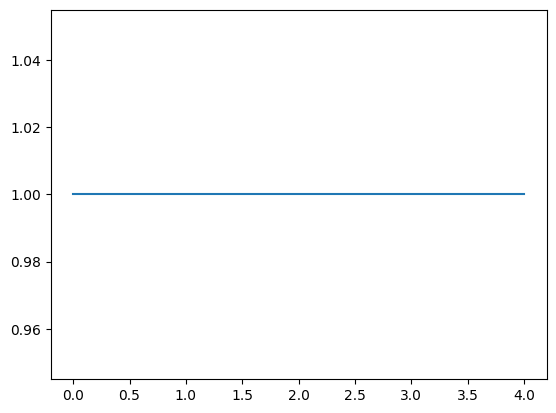

In [4]:
kernel = windows.boxcar(5)
plt.plot(kernel)

Plot boxcar kernel with window length 2

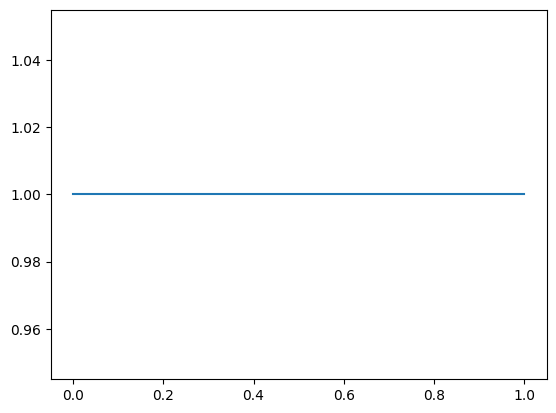

In [5]:
kernel = windows.boxcar(2)
plt.plot(kernel)

Plot boxcar kernel with window length 1


When we create a boxcar kernel with a window size of 1, it only contains a single value. This means the kernel is just `[1.0]`, with no other points before or after it. 

When we try to plot it using `plt.plot()`, it does not look like a curve or a line because there is only one point to show. That is why the plot appears empty or flat — we need at least two points to see a visible shape.

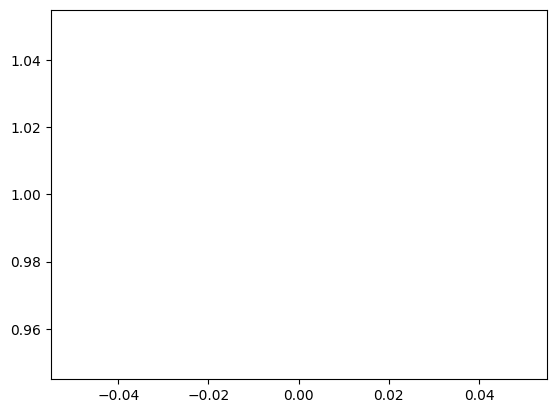

In [6]:
kernel = windows.boxcar(1)
plt.plot(kernel)

**Example** Convolve with window length 5

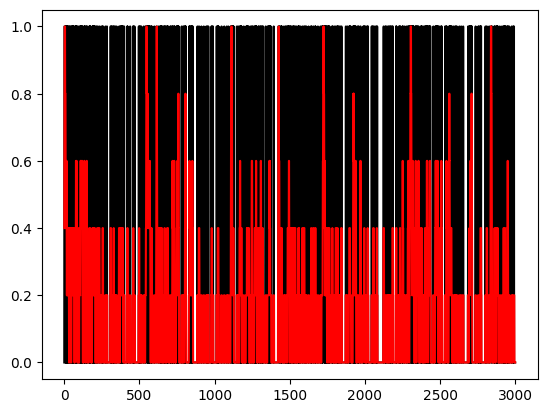

In [7]:
kernel_unnorm = windows.boxcar(5)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with window length 25

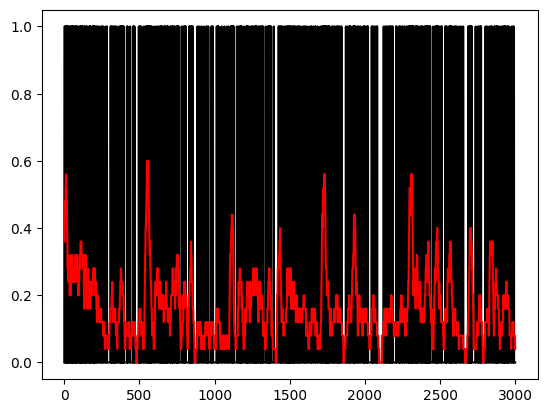

In [8]:
kernel_unnorm = windows.boxcar(25)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with window length 1000

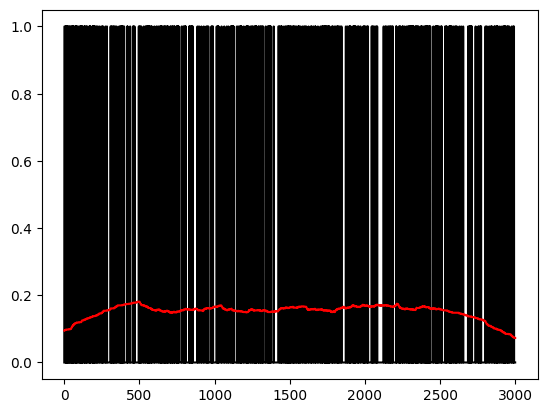

In [9]:
kernel_unnorm = windows.boxcar(1000)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with window length 1

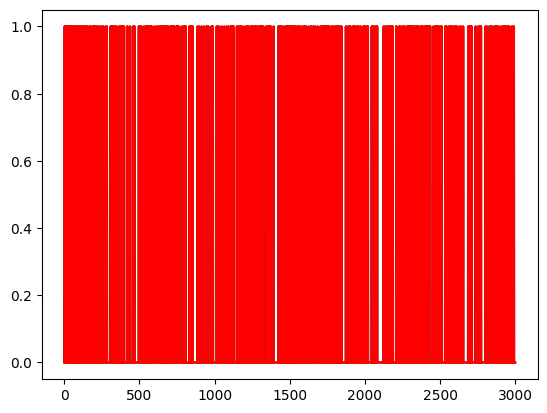

In [10]:
kernel_unnorm = windows.boxcar(1)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Now that we have seen how the window size affects the result of convolution, let us also look at how the **shape of the kernel** changes the output.

A **triangular kernel** gives more importance to the center of the window and less to the edges. This creates a smoother and softer curve. It can help show the overall pattern of spikes without adding too much noise.

A **boxcar kernel** gives equal importance to every point in the window. This can create more sharp changes in the signal and often shows more small peaks. However, these extra peaks can sometimes be noisy or less meaningful.

Even when both kernels use the same window size, they behave differently. The triangular kernel smooths gently, while the boxcar kernel can make the signal look more jagged.

**Example** Plot triangular kernel with window 25

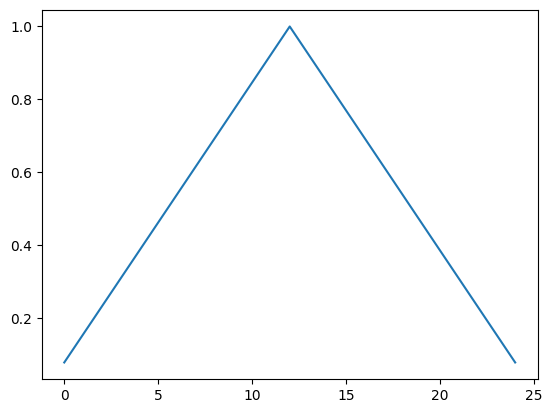

In [11]:
kernel = windows.triang(25)
plt.plot(kernel)

Plot triangular kernel with window 26

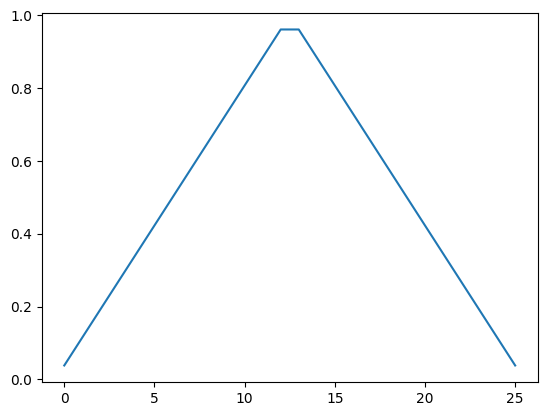

In [12]:
kernel = windows.triang(26)
plt.plot(kernel)

When we use an **even window length** for the triangular kernel, the peak of the triangle is spread across two values in the center instead of having a single sharp peak. This creates a small flat region at the top of the kernel. Instead of producing a smooth, pointed response around each spike, the convolution may produce a response that is slightly broader and flatter at the top. This can reduce the precision of peak locations in the output, especially when dealing with closely spaced spikes. For cleaner and more symmetric smoothing, it is usually better to use an **odd window length** for triangular kernels.

**Example** Convolve with triangular kernel (window=25)

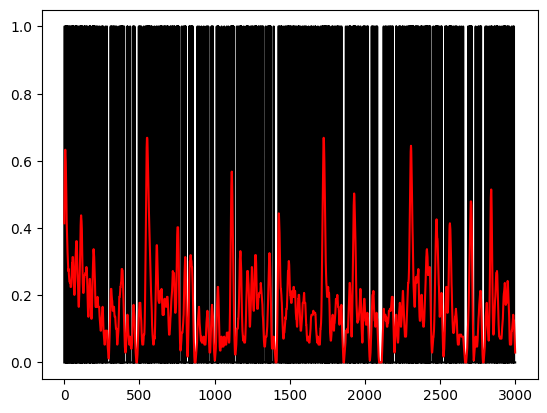

In [13]:
kernel_unnorm = windows.triang(25)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with triangular kernel (window=1001)

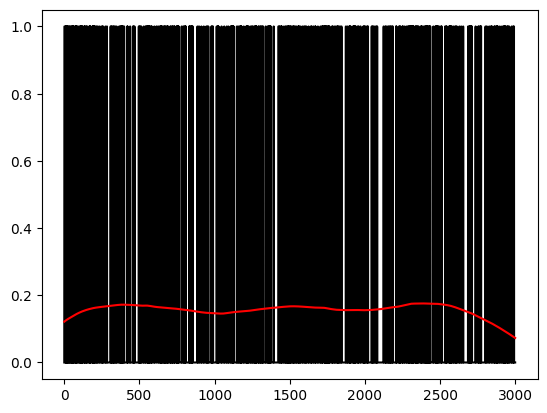

In [14]:
kernel_unnorm = windows.triang(1001)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Compare with triangular kernel and rectangular kernel (window=501)

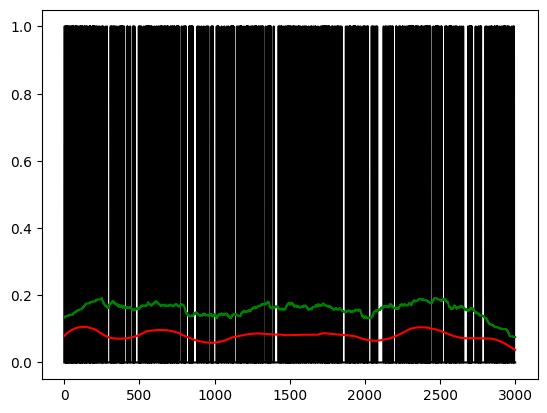

In [15]:
kernel_tri_unnorm= windows.triang(501)
kernel_tri = kernel_tri_unnorm / kernel_unnorm.sum()

kernel_box_unnorm = windows.boxcar(501)
kernel_box = kernel_box_unnorm / kernel_unnorm.sum()

convolved_trace_tri = convolve(spike_train, kernel_tri, mode='same')
convolved_trace_box = convolve(spike_train, kernel_box, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace_tri, color='r')
plt.plot(convolved_trace_box, color='g')

The **Gaussian kernel** is a smooth, bell-shaped curve controlled by two key parameters: the **window length**, which sets how many points the kernel covers, and the **standard deviation**, which determines how wide or narrow the bell curve is inside that window.

A small standard deviation produces a sharp, narrow curve that focuses on local values, while a large standard deviation spreads the weights more evenly across the window, leading to heavier smoothing. 

**Example** Plot a gaussian kernel with window length 25 and std=1

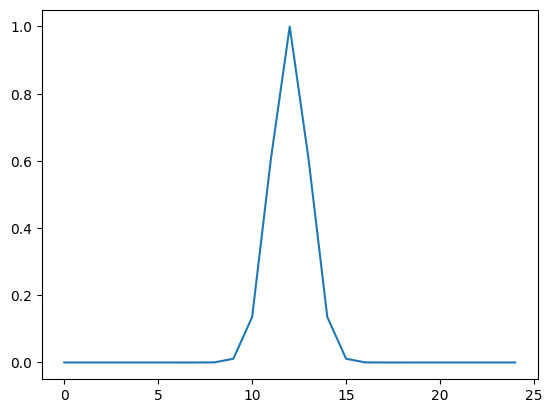

In [16]:
kernel = windows.gaussian(25, std=1)
plt.plot(kernel)

Plot a gaussian kernel with window length 25 and std=15

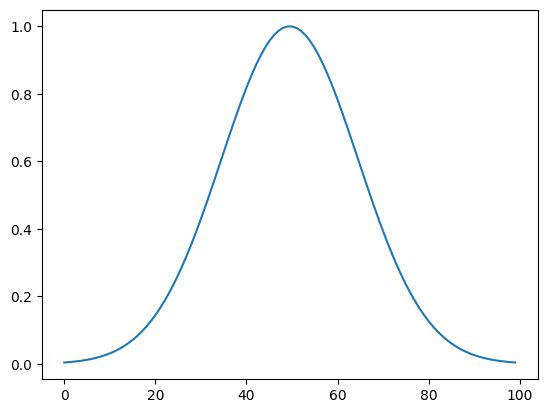

In [17]:
kernel = windows.gaussian(100, std=15)
plt.plot(kernel)

Plot a gaussian kernel with window length 200 and std=100

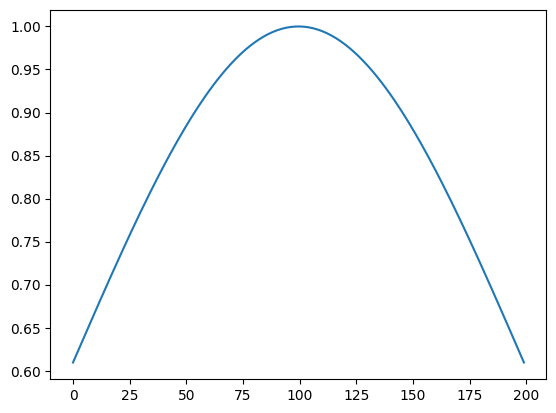

In [18]:
kernel = windows.gaussian(200, std=100)
plt.plot(kernel)

Convolve with gaussian kernel (window=25, std=1)

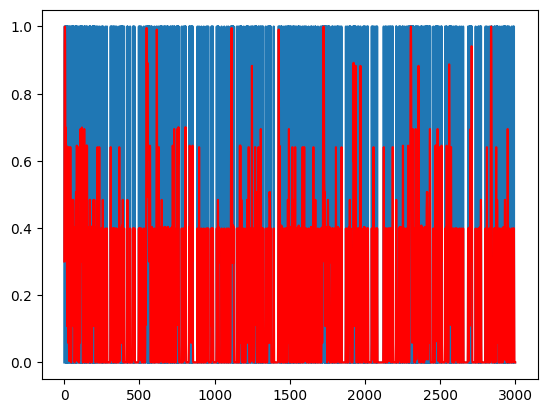

In [19]:
kernel_unnorm = windows.gaussian(25, std=1)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train)
plt.plot(convolved_trace, color='r')

Convolve with gaussian kernel (window=100, std=15)

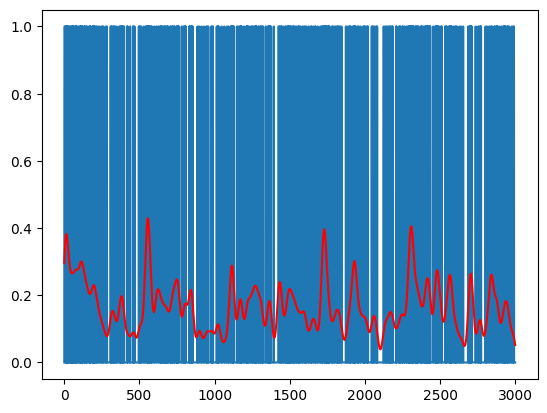

In [20]:
kernel_unnorm = windows.gaussian(100, std=15)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train)
plt.plot(convolved_trace, color='r')

Convolve with gaussian kernel (window=200, std=100)

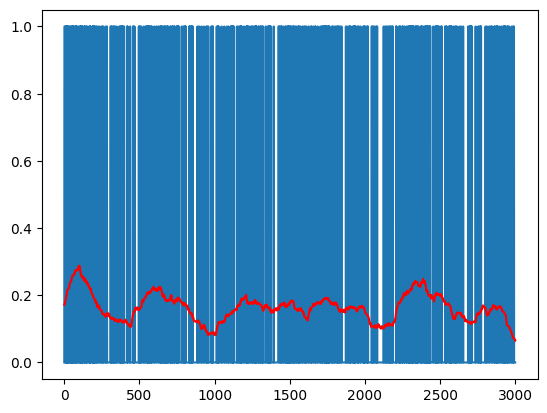

In [21]:
kernel_unnorm = windows.gaussian(200, std=100)
kernel = kernel_unnorm / kernel_unnorm.sum()
convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train)
plt.plot(convolved_trace, color='r')

### Convolution with Calcium Spike Transient Kernel

Now you will make your model more realistic. Calcium signals do not rise and fall instantly. Instead, they rise quickly after a spike and then decay slowly. You will use a calcium kernel that mimics this behavior. When you convolve this kernel with a spike train, you will get a signal that looks more like what you see in real experiments. 


The **exponential decay kernel** models the calcium signal that follows a spike. It starts with a high value and then decreases smoothly over time, capturing the way calcium levels rise quickly and then slowly fall back down after neural activity.

This kernel is controlled by a single parameter called the **decay time constant** (tau), which determines how quickly the signal fades. A small tau produces a fast decay, while a large tau causes the signal to fall more slowly. To apply this decay over time, we use an array `t` to represent each time step after a spike. The equation `exp(-t / tau)` tells us how much the signal should decrease at each step. The unit of tau depends on the data: in synthetic simulations, it is measured in time steps or samples, while in real calcium imaging data, tau is measured in **frames** and can be converted into seconds using the sampling rate (frames per second).

**Example** Plot exponential decay kernel (tau = 5, length = 100)

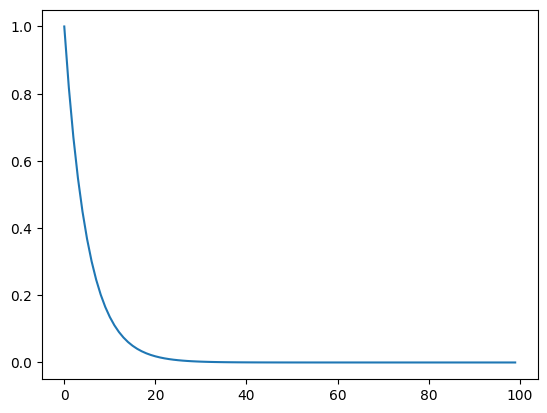

In [22]:
tau = 5
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau)
plt.plot(kernel)

Plot exponential decay kernel (tau = 20, length = 100)

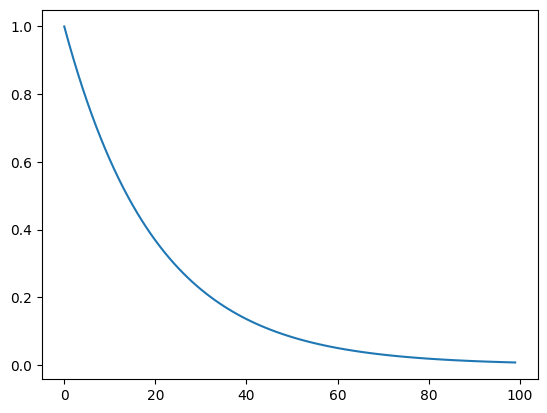

In [23]:
tau = 20
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau)
plt.plot(kernel)

Plot exponential decay kernel (tau = 50, length = 100)

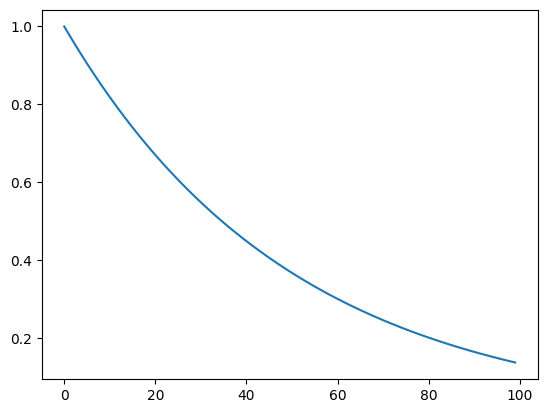

In [24]:
tau = 50
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau)

plt.plot(kernel)

**Example** Convolve with exponential decay calcium transient (tau=20, window=100)

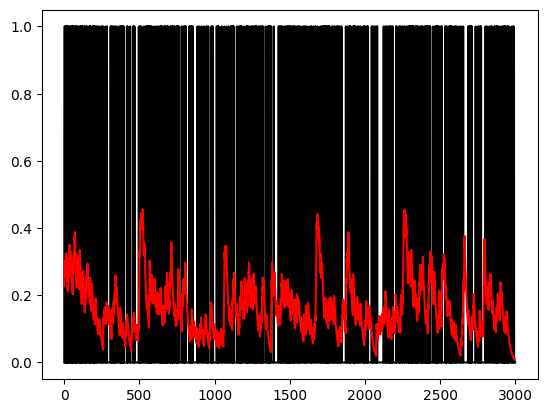

In [25]:
tau = 20
length = 100
t = np.arange(length)
kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with exponential decay calcium transient (tau=50, window=100)

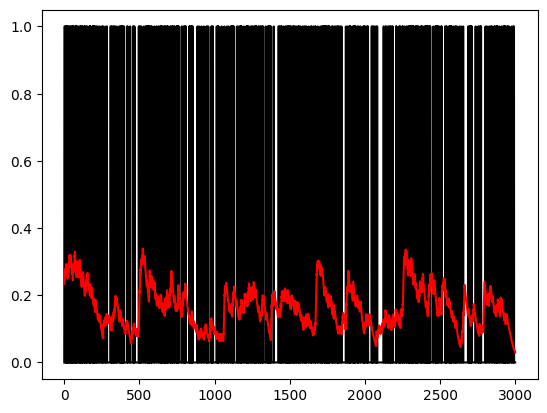

In [26]:
tau = 50
length = 100
t = np.arange(length)
kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')


plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with exponential decay calcium transient (tau=5, window=100)

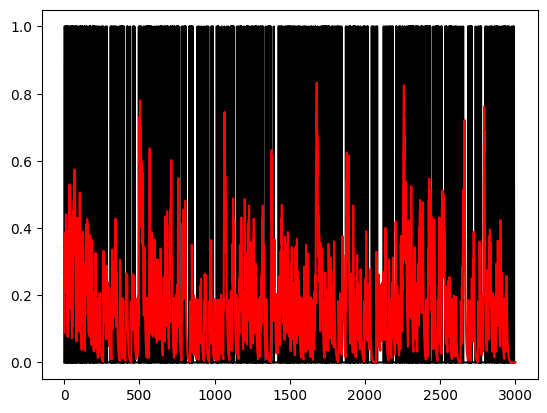

In [27]:
tau = 5
length = 100
t = np.arange(length)
kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

The **double exponential decay kernel** gives a more realistic model of calcium transients than the single exponential. Instead of assuming an immediate rise after a spike, it captures both the rise and decay phases using two time constants:
- **tau_rise** controls how quickly the signal increases after a spike.
- **tau_decay** controls how slowly it fades back down.

The kernel is defined as the difference between two exponential functions — one for the decay and one for the rise:

    k(t) = exp(-t / tau_decay) - exp(-t / tau_rise)

The result is a curve that starts at zero, rises quickly to a peak, and then decays gradually — similar to how calcium signals behave in real imaging data.

Let us see the effect of `tau_decay`, `tau_rise`, and their combination affects the kernel shape and eventually, our convolved trace.

Increasing `tau_rise` makes the kernel rise more slowly, delaying the peak and smoothing the initial slope.

A smaller `tau_rise` creates a sharper, faster onset, which better resembles the quick calcium increase after a spike in real data.

**Example** Plot double exponential kernel (rise=3, decay=30)

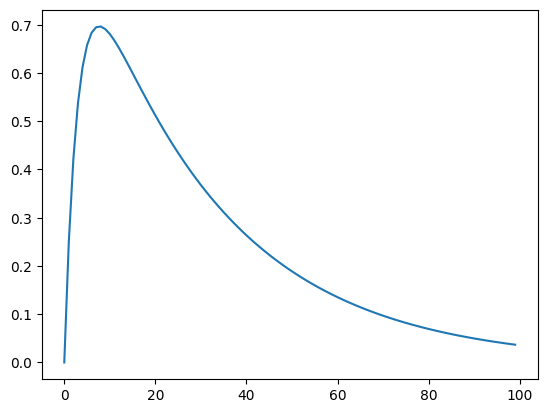

In [28]:
tau_rise = 3
tau_decay = 30
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=10, decay=30)

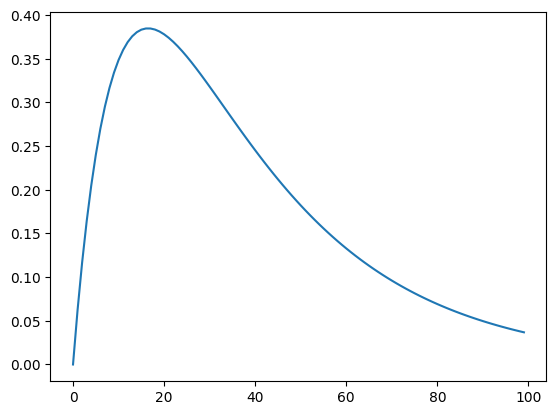

In [29]:
tau_rise = 10
tau_decay = 30
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=20, decay=30)

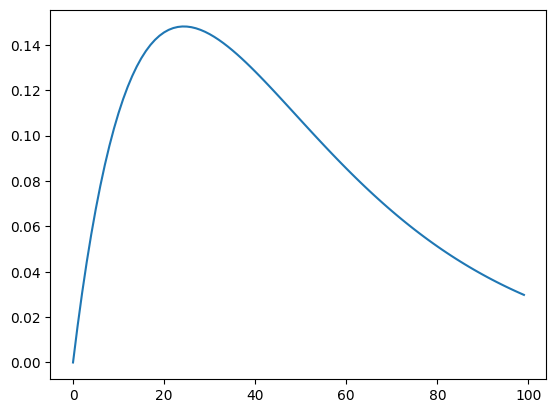

In [30]:
tau_rise = 20
tau_decay = 30
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Increasing `tau_decay` makes the kernel decay more slowly, stretching the signal over a longer period.

A smaller `tau_decay` causes the signal to fall quickly, resulting in a shorter-lasting transient.

Plot double exponential kernel (rise=5, decay=20)

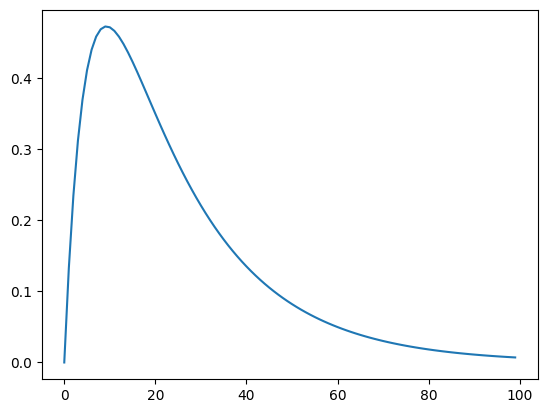

In [31]:
tau_rise = 5
tau_decay = 20
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=5, decay=40)

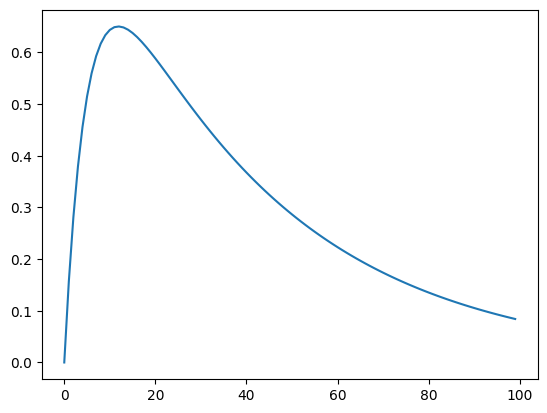

In [32]:
tau_rise = 5
tau_decay = 40
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

Plot double exponential kernel (rise=5, decay=80)

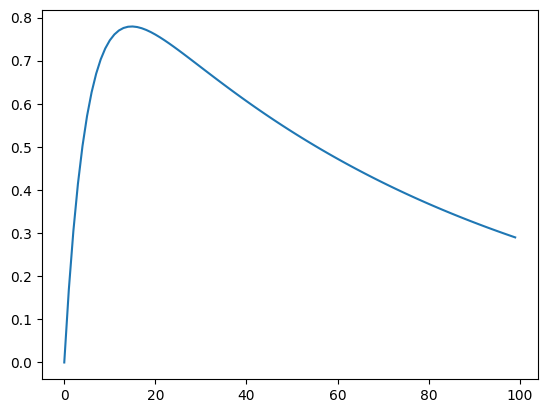

In [33]:
tau_rise = 5
tau_decay = 80
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

plt.plot(kernel)

When `tau_rise` is greater than `tau_decay`, the kernel becomes invalid for calcium modeling — it may start negative or have no clear rise.

When `tau_rise` equals `tau_decay`, the two exponentials cancel each other out and the kernel becomes flat (zero everywhere).

To create a realistic calcium transient, `tau_rise`<`tau_decay`. This ensures a fast rise and slow decay, matching the typical shape of calcium signals after a spike.

Plot double exponential kernel (rise=20, decay=20)

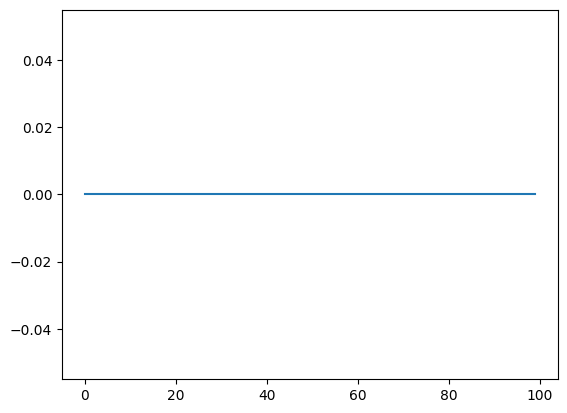

In [34]:
tau_rise = 20
tau_decay = 20
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
plt.plot(kernel)

Plot double exponential kernel (rise=20, decay=10)

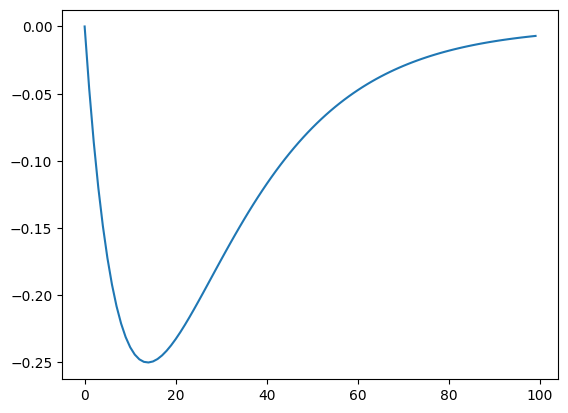

In [35]:
tau_rise = 20
tau_decay = 10
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
plt.plot(kernel)

**Example** Convolve with double exponential decay calcium transient (tau_rise=5, tau_decay=30) 

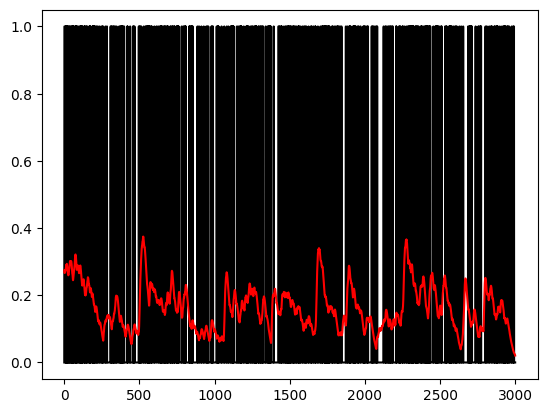

In [36]:
tau_rise = 5
tau_decay = 30
length = 100
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)
kernel = kernel_unnorm / kernel_unnorm.sum()

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with double exponential decay calcium transient (tau_rise=20, tau_decay=20) 

Hint: Use unnormalized kernel for convolution.

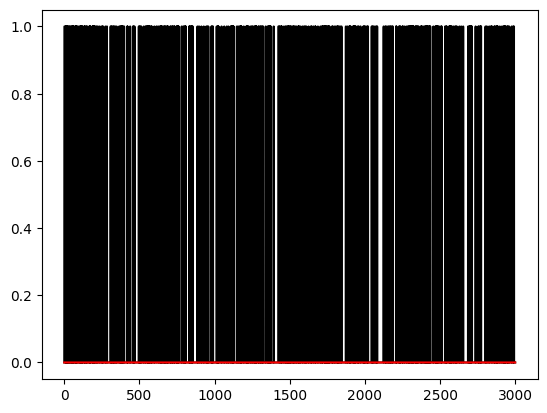

In [37]:
tau_rise = 20
tau_decay = 20
length = 100
t = np.arange(length)

kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

Convolve with double exponential decay calcium transient (tau_rise=30, tau_decay=10) 

Hint: Use unnormalized kernel for convolution.

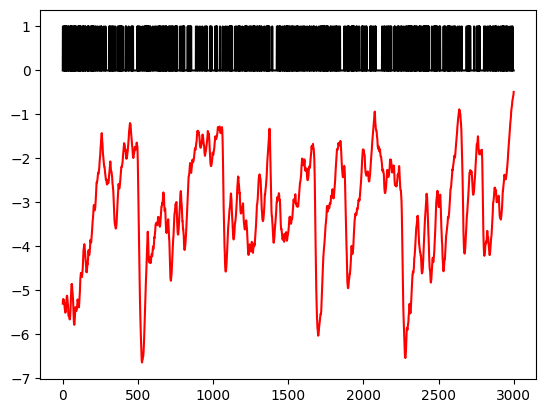

In [38]:
tau_rise = 30
tau_decay = 10
length = 100
t = np.arange(length)
kernel = np.exp(-t / tau_decay) - np.exp(-t / tau_rise)

convolved_trace = convolve(spike_train, kernel, mode='same')

plt.plot(spike_train, color='k')
plt.plot(convolved_trace, color='r')

### Deconvolution using `scipy.signal.deconvolve`

In calcium imaging experiments, what we record are fluorescence traces — smooth and delayed signals that reflect the activity of neurons. These traces are not spikes themselves, but they are shaped by underlying spike events. To analyze neural activity more directly, we often want to estimate when these spikes occurred based on the observed calcium signal.

This process is known as **deconvolution**. The goal is to extract an estimate of spike timing or spike intensity from a calcium trace by inverting the effect of calcium dynamics. Since we already understand how a spike leads to a smoothed calcium signal, we can now use that understanding to work in the other direction: interpreting the fluorescence data to infer spikes. In convolution, we started with a spike train and a kernel to produce a smooth signal. Deconvolution works in the opposite direction. We start with a smooth calcium trace and try to recover the discrete spike events that likely caused it.

To do this, we need two things:

1. **A calcium trace** — this is the signal we get from calcium imaging. It is the observed data, and it carries information about when spikes may have occurred.
2. **A model of how spikes affect the calcium trace** — usually represented as a `kernel`. This could be an exponential or double exponential kernel, as we have explored before. It tells us how we think a single spike contributes to the trace.

**Example** Deconvolve raw trace with exponential kernel (widow=100)

In [39]:
tau = 5
length = 100
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

deconvolve_trace, _ = deconvolve(cal_trace, kernel)

deconvolve_trace.shape

(2901,)

Deconvolve raw trace with exponential kernel (widow=500)

In [40]:
tau = 5
length = 500
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

deconvolve_trace, _ = deconvolve(cal_trace, kernel)

deconvolve_trace.shape

(2501,)

Deconvolve raw trace with exponential kernel (widow=5)

In [41]:
tau = 5
length = 10
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

deconvolve_trace, _ = deconvolve(cal_trace, kernel)

deconvolve_trace.shape

(2991,)

The deconvolution output is shorter than the calcium trace because the kernel cannot fully slide to the end of the signal. Padding is used to make the deconvolved output the same length as the calcium trace, so they can be plotted and compared on the same time axis.

However, the padded values do not contain meaningful spike estimates — they are simply zeros added for visual alignment. We should not interpret anything from the padded region. Only the portion of the deconvolved output before padding contains actual information about spike activity.

**Example** Deconvolve raw trace with exponential kernel (tau=5, widow=100) and plot after padding.

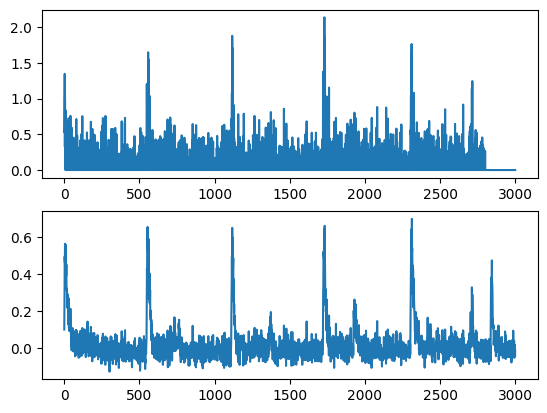

In [42]:
tau = 5
length = 200
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

deconvolve_trace, _ = deconvolve(cal_trace, kernel)
pad_len = len(cal_trace) - len(deconvolve_trace)
deconvolve_trace = np.pad(deconvolve_trace, (0, pad_len))
deconvolve_trace = np.clip(deconvolve_trace, 0, None)

plt.subplot(211)
plt.plot(deconvolve_trace)

plt.subplot(212)
plt.plot(cal_trace)

Deconvolve raw trace with exponential kernel (tau=10, widow=200) and plot after padding.

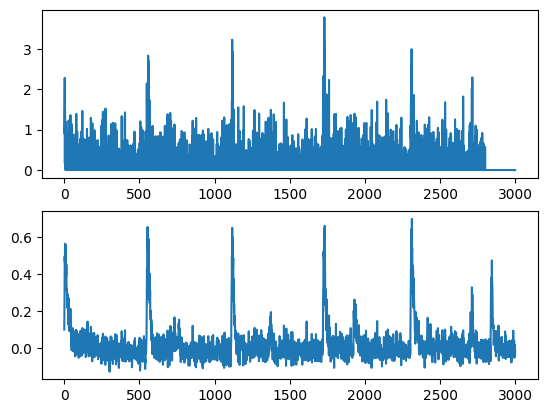

In [43]:
tau = 10
length = 200
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

deconvolve_trace, _ = deconvolve(cal_trace, kernel)
pad_len = len(cal_trace) - len(deconvolve_trace)
deconvolve_trace = np.pad(deconvolve_trace, (0, pad_len))
deconvolve_trace = np.clip(deconvolve_trace, 0, None)

plt.subplot(211)
plt.plot(deconvolve_trace)

plt.subplot(212)
plt.plot(cal_trace)

Deconvolve raw trace with exponential kernel (tau=60, widow=200) and plot after padding.

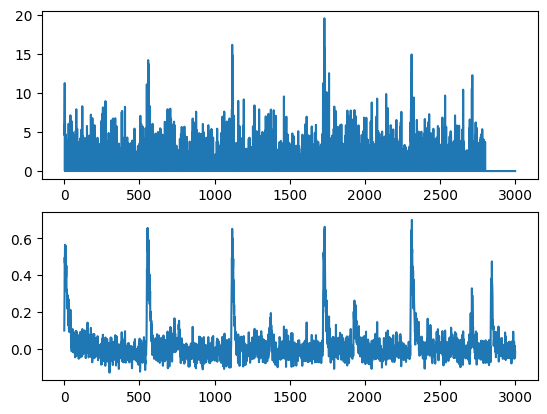

In [44]:
tau = 60
length = 200
t = np.arange(length)

kernel_unnorm = np.exp(-t / tau)
kernel = kernel_unnorm / kernel_unnorm.sum()

deconvolve_trace, _ = deconvolve(cal_trace, kernel)
pad_len = len(cal_trace) - len(deconvolve_trace)
deconvolve_trace = np.pad(deconvolve_trace, (0, pad_len))
deconvolve_trace = np.clip(deconvolve_trace, 0, None)


plt.subplot(211)
plt.plot(deconvolve_trace)

plt.subplot(212)
plt.plot(cal_trace)

Simple deconvolution gives us a quick way to guess when spikes might have happened, but it has several problems. The output often includes values that are too large, too small, or even negative — which do not make sense for real spikes. It is also very sensitive to small changes or noise in the calcium signal, which can lead to messy results. This method does not know how calcium signals normally rise and fall, and it does not try to make the spikes sparse or positive. Also, the output is shorter than the original calcium trace, so we have to add padding just to compare them. Because of all these issues, simple deconvolution is not reliable.

AR(1), or first-order auto-regressive model, is a simple way to describe how calcium signals change over time in response to spikes. It assumes that the calcium signal at each time point depends on a portion of the previous signal and any new spike that occurred. This models the natural behavior of calcium: it rises quickly when a spike happens and then slowly fades away. To use AR(1), we need the calcium trace and a decay constant called gamma, which tells us how quickly the signal decreases over time. Once we have those, we can estimate when spikes occurred by checking how much the calcium signal increases beyond what we would expect from normal decay.

**Example** Estimate spikes from calcium trace using AR(1) model (gamma = 0.7) and plot.

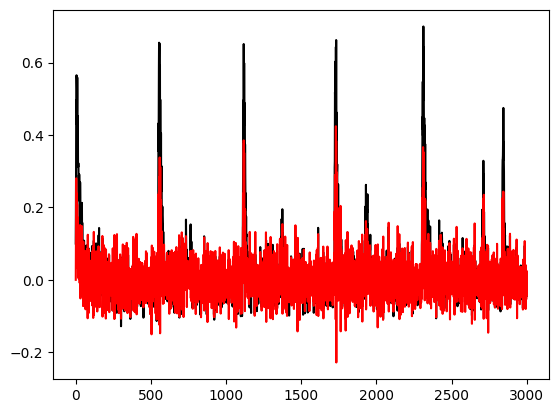

In [45]:
gamma = 0.7
calcium = cal_trace.copy()
decon = np.zeros_like(calcium)
decon[1:] = calcium[1:] - gamma * calcium[:-1]
s_est = np.clip(decon, 0, None)

plt.plot(calcium, color='k')
plt.plot(decon, color='r')

Estimate spikes from calcium trace using AR(1) model (gamma = 0.1) and plot.

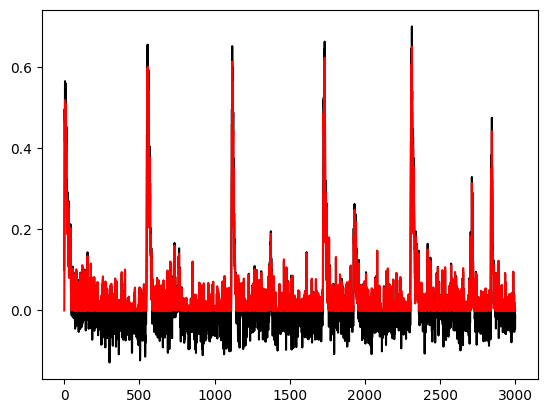

In [46]:
gamma = 0.1
calcium = cal_trace.copy()
decon = np.zeros_like(calcium)
decon[1:] = calcium[1:] - gamma * calcium[:-1]
decon = np.clip(decon, 0, None)

plt.plot(calcium, color='k')
plt.plot(decon, color='r')

Estimate spikes from calcium trace using AR(1) model (gamma = 0.9) and plot.

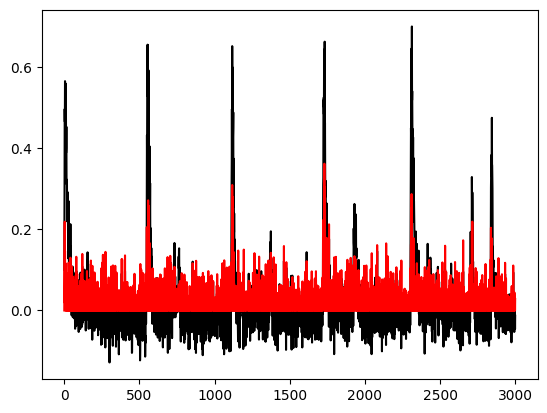

In [47]:
gamma = 0.9
calcium = cal_trace.copy()
decon = np.zeros_like(calcium)
decon[1:] = calcium[1:] - gamma * calcium[:-1]
decon = np.clip(decon, 0, None)

plt.plot(calcium, color='k')
plt.plot(decon, color='r')

### Deconvolution Using OASIS

So far, we have explored simple ways to estimate spikes from calcium traces, such as using AR(1) or AR(2) models directly. While these approaches build helpful intuition, they have limitations — they may produce noisy results, allow negative spikes, or require manual tuning to get accurate estimates.

To overcome these challenges, we now use **OASIS** (Online Active Set method to Infer Spikes), a widely used and efficient method for calcium signal deconvolution. OASIS assumes a model of calcium dynamics (such as AR(1) or AR(2)) and uses an optimization-based approach to recover a non-negative, sparse estimate of the underlying spike activity. It automatically adjusts model parameters and works well even when spikes are close together or the data is noisy.

**Example** Deconvolve using OASIS

c:\Users\sangeetha\miniforge3\envs\calim\Lib\site-packages\oasis\functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


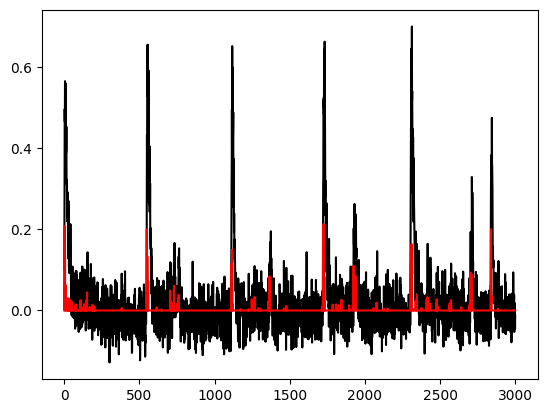

In [48]:
_, deconvolve_trace, _, _, _ = oasis_deconvolve(cal_trace)

plt.plot(cal_trace, color='k')
plt.plot(deconvolve_trace, color='r')

AR(1) model with gamma=0.98

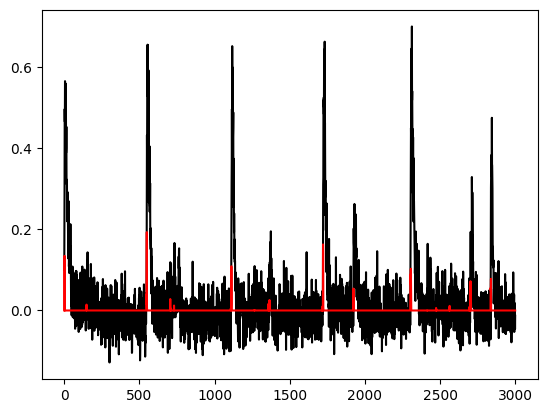

In [49]:
_, deconvolve_trace, _, _, _ = oasis_deconvolve(cal_trace, g=(0.98,))

plt.plot(cal_trace, color='k')
plt.plot(deconvolve_trace, color='r')

AR(1) model with gamma=0.1

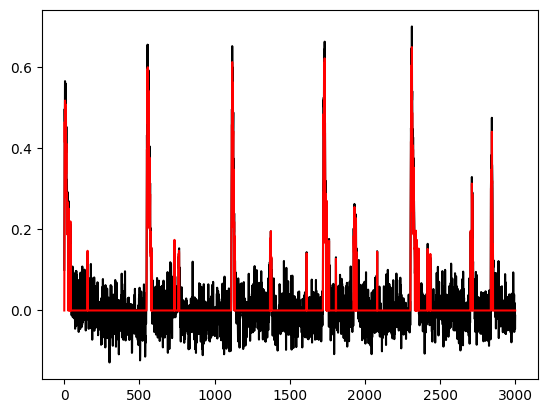

In [50]:
_, deconvolve_trace, _, _, _ = oasis_deconvolve(cal_trace, g=(0.1,))

plt.plot(cal_trace, color='k')
plt.plot(deconvolve_trace, color='r')

AR(1) model with gamma=0.7

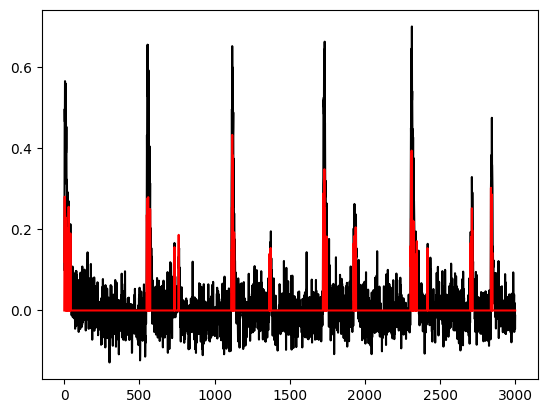

In [51]:
_, deconvolve_trace, _, _, _ = oasis_deconvolve(cal_trace, g=(0.7,))

plt.plot(cal_trace, color='k')
plt.plot(deconvolve_trace, color='r')